Add Starting Pitching to Model

    In the last notebook we augmented our dataframe to include various features based on the starting pitcher's performance
    Now we will add these features in to see how much improvement we get to our model.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgbm
import structureboost as stb
import ml_insights as mli
from structureboost import log_loss
pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)

In [3]:
df = pd.read_csv('df_bp5.csv', low_memory=False)

BEGIN MODELING

In [4]:
df = df[df.run_diff!=0]
df_train = df[(df.season>2000) & (df.season<=2015)]
df_valid = df[(df.season>=2016) & (df.season<=2020)]
df_test = df[df.season>=2021]

In [5]:
hv_mean = df_train.home_victory.mean()

FIRST -- Just add in ERA and WHIP over last 35 games (in addition to first model params)

In [6]:
features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            'Strt_ERA_14_h','Strt_ERA_14_v',
            'Strt_WHIP_14_h','Strt_WHIP_14_v', 
]
target = 'home_victory'

In [7]:
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

In [8]:
X_train.shape, X_valid.shape, X_test.shape

((36437, 8), (10615, 8), (7285, 8))

In [9]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=2)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.689633
[20]	valid_0's binary_logloss: 0.688862
[30]	valid_0's binary_logloss: 0.688195
[40]	valid_0's binary_logloss: 0.687603
[50]	valid_0's binary_logloss: 0.687027
[60]	valid_0's binary_logloss: 0.686567
[70]	valid_0's binary_logloss: 0.68602
[80]	valid_0's binary_logloss: 0.685616
[90]	valid_0's binary_logloss: 0.68523
[100]	valid_0's binary_logloss: 0.684947
[110]	valid_0's binary_logloss: 0.684631
[120]	valid_0's binary_logloss: 0.684338
[130]	valid_0's binary_logloss: 0.684031
[140]	valid_0's binary_logloss: 0.683793
[150]	valid_0's binary_logloss: 0.683547
[160]	valid_0's binary_logloss: 0.683356
[170]	valid_0's binary_logloss: 0.683171
[180]	valid_0's binary_logloss: 0.682958
[190]	valid_0's binary_logloss: 0.682789
[200]	valid_0's binary_logloss: 0.68264
[210]	valid_0's binary_logloss: 0.682505
[220]	valid_0's binary_logloss: 0.682366
[230]	valid_0's binary_logloss: 0.682223
[240]	va

LGBMClassifier(learning_rate=0.02, max_depth=2, n_estimators=1000)

In [10]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

In [11]:
# previous model gave 0.6853993814658048
log_loss(y_test, preds_lgbm), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.6813063097157772, 0.6913722730242492)

In [12]:
log_loss(y_test,df_test.implied_prob_h_mid)

0.6704071693200951

It would behoove us to be define a way to quantify to relate our models both to the Las Vegas oddsmakers model and if we were to "naively" select the home team 53.8% of the time because that's what seems to happen.

As a reminder, our models include:

    - Simple (first): OBP & SLG
    - Current: OBP, SLG, + Starting Pitcher ERA and WHIP over their past 14 starts

We will define a 'basis point' (bp) to be log_loss = 0.0001

This will allow us to relate the models to each other and using more familiar integer values

In [13]:
# naive-LV, naive-simp_mod, naive-current_mod

np.round([0.6905 - 0.6676, 0.6905 - 0.6854, 0.6905 - 0.6704], decimals=4)

array([0.0229, 0.0051, 0.0201])

In [14]:
rd = mli.get_range_dict(X_train)
plot_pts = X_test.sample(3, random_state=42)

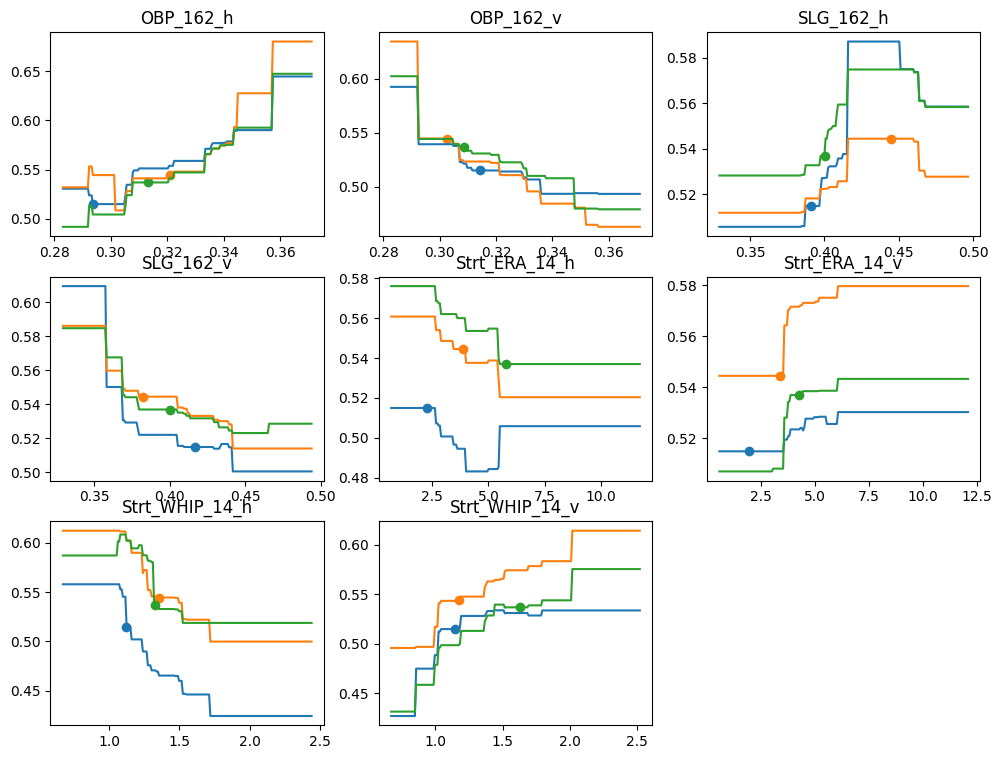

In [15]:
mli.ice_plot(lgbm1, plot_pts, X_test.columns, mli.get_range_dict(X_train), plots_per_row=3)

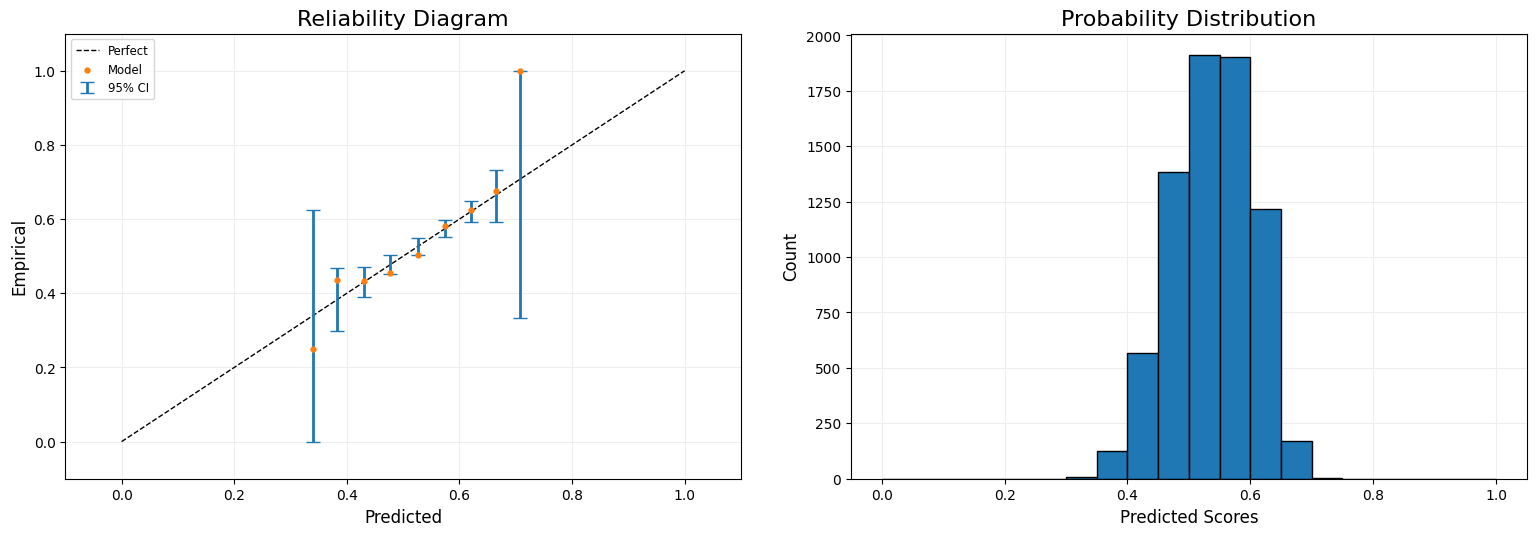

In [16]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_lgbm, show_histogram=True);

In [17]:
sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
sv_lgbm = pd.DataFrame(sv_lgbm)
sv_lgbm.columns = list(X_test.columns)+['Intercept']

In [18]:
# This shows for each game, how the different features affected 

sv_lgbm.head(5).round(3)

,OBP_162_h,OBP_162_v,SLG_162_h,SLG_162_v,Strt_ERA_14_h,Strt_ERA_14_v,Strt_WHIP_14_h,Strt_WHIP_14_v,Intercept
0,-0.041,0.076,0.061,0.029,0.028,0.024,0.151,0.030,0.165
1,-0.051,0.047,0.070,0.027,0.001,-0.066,0.127,-0.247,0.165
2,-0.045,-0.001,0.053,-0.081,0.001,-0.077,-0.000,-0.262,0.165
3,-0.122,0.020,-0.136,-0.010,0.023,-0.053,0.142,-0.068,0.165
4,-0.046,-0.000,0.101,-0.080,0.035,-0.053,0.162,-0.333,0.165


In [19]:
sv_lgbm.abs().mean().sort_values(ascending=False)

Intercept         0.164814
Strt_WHIP_14_h    0.090747
OBP_162_h         0.066912
OBP_162_v         0.065893
SLG_162_h         0.063487
Strt_WHIP_14_v    0.063428
Strt_ERA_14_v     0.039516
SLG_162_v         0.035173
Strt_ERA_14_h     0.029753
dtype: float64

Let's add in a few more pitching features...

In [20]:
# Add in SO% and "Modified Slugging Against"

features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            'Strt_ERA_14_h','Strt_ERA_14_v',
            'Strt_WHIP_14_h','Strt_WHIP_14_v',
            'Strt_SO_perc_14_h', 'Strt_SO_perc_14_v',
            'Strt_TB_BB_perc_14_h', 'Strt_TB_BB_perc_14_v',
            'Strt_H_BB_perc_14_h', 'Strt_H_BB_perc_14_v',
]
target = 'home_victory'

In [21]:
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

In [22]:
X_train.shape, X_valid.shape, X_test.shape

((36437, 14), (10615, 14), (7285, 14))

In [23]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=2)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.68989
[20]	valid_0's binary_logloss: 0.689117
[30]	valid_0's binary_logloss: 0.688436
[40]	valid_0's binary_logloss: 0.687705
[50]	valid_0's binary_logloss: 0.68697
[60]	valid_0's binary_logloss: 0.686383
[70]	valid_0's binary_logloss: 0.685925
[80]	valid_0's binary_logloss: 0.685373
[90]	valid_0's binary_logloss: 0.684936
[100]	valid_0's binary_logloss: 0.684453
[110]	valid_0's binary_logloss: 0.684092
[120]	valid_0's binary_logloss: 0.683777
[130]	valid_0's binary_logloss: 0.683487
[140]	valid_0's binary_logloss: 0.683179
[150]	valid_0's binary_logloss: 0.682953
[160]	valid_0's binary_logloss: 0.682655
[170]	valid_0's binary_logloss: 0.682427
[180]	valid_0's binary_logloss: 0.682206
[190]	valid_0's binary_logloss: 0.68205
[200]	valid_0's binary_logloss: 0.681839
[210]	valid_0's binary_logloss: 0.681687
[220]	valid_0's binary_logloss: 0.681546
[230]	valid_0's binary_logloss: 0.681403
[240]	va

LGBMClassifier(learning_rate=0.02, max_depth=2, n_estimators=1000)

In [24]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

In [25]:
log_loss(y_test, preds_lgbm), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.6800675320371905, 0.6913722730242492)

Note that adding those two features improved the model by a mere 1 bp

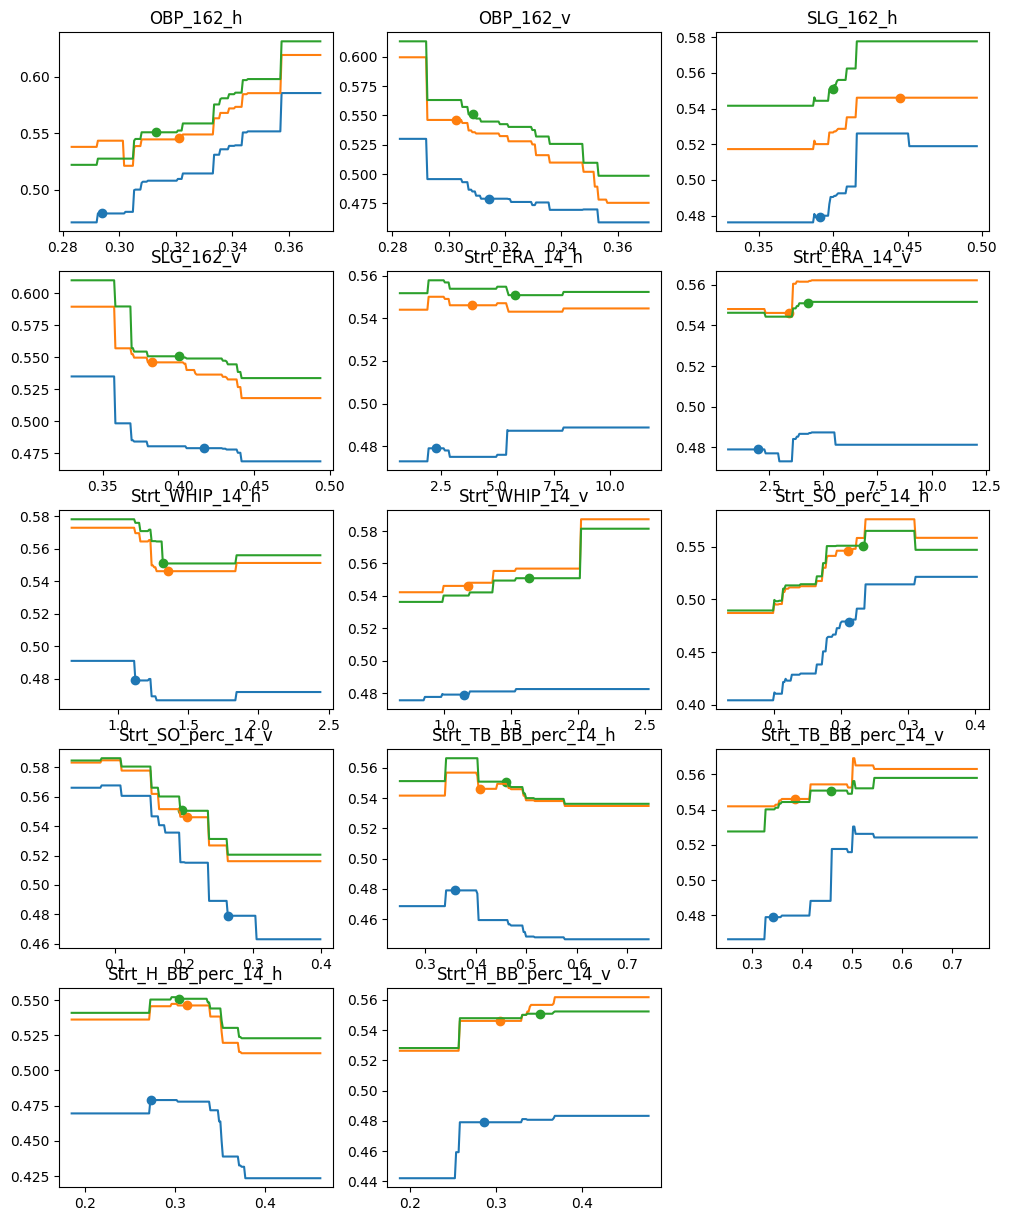

In [26]:
rd = mli.get_range_dict(X_train)
plot_pts = X_test.sample(3, random_state=42)

mli.ice_plot(lgbm1, plot_pts, X_test.columns, mli.get_range_dict(X_train), plots_per_row=3)

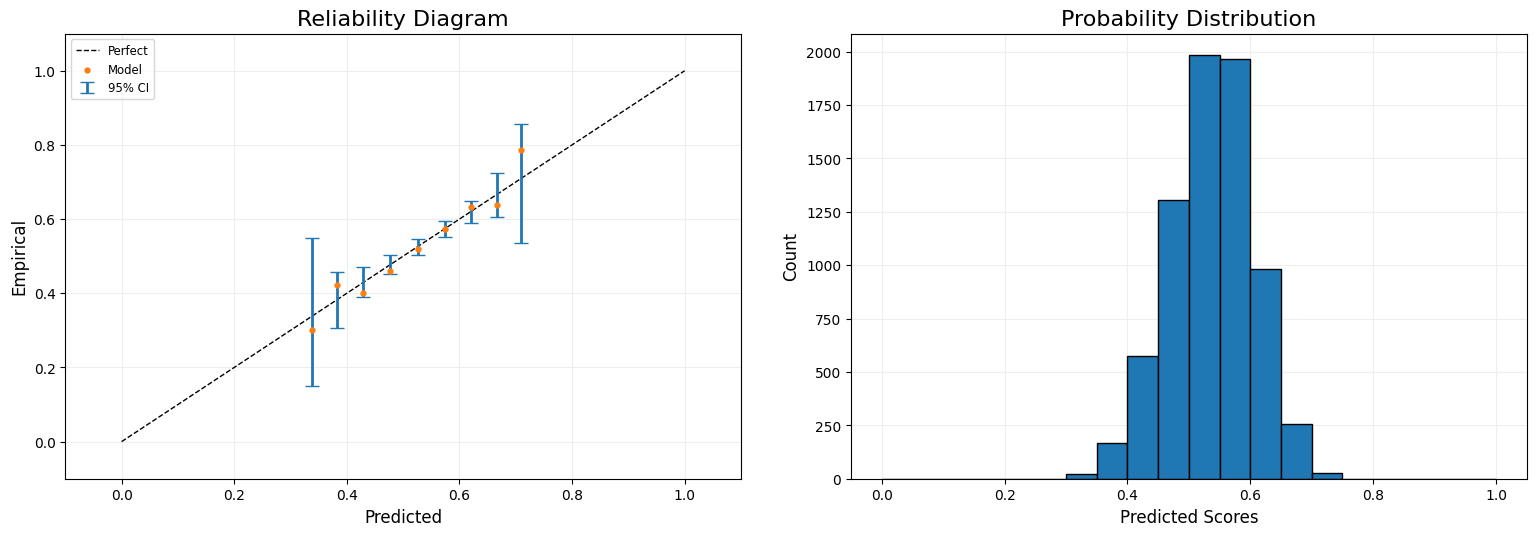

In [27]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_lgbm, show_histogram=True);

In [28]:
sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
sv_lgbm = pd.DataFrame(sv_lgbm)
sv_lgbm.columns = list(X_test.columns)+['Intercept']

In [29]:
sv_lgbm.abs().mean().sort_values(ascending=False)

Intercept               0.165050
Strt_SO_perc_14_v       0.099917
Strt_SO_perc_14_h       0.092678
OBP_162_v               0.061522
OBP_162_h               0.059921
SLG_162_h               0.052828
Strt_WHIP_14_h          0.045284
SLG_162_v               0.029490
Strt_H_BB_perc_14_h     0.024126
Strt_H_BB_perc_14_v     0.023553
Strt_TB_BB_perc_14_h    0.023550
Strt_TB_BB_perc_14_v    0.021127
Strt_ERA_14_v           0.017784
Strt_WHIP_14_v          0.014404
Strt_ERA_14_h           0.004686
dtype: float64

In [30]:
## Let's add in the 10 game lookback features
features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            'Strt_ERA_14_h','Strt_ERA_14_v',
            'Strt_WHIP_14_h','Strt_WHIP_14_v',
            'Strt_SO_perc_14_h', 'Strt_SO_perc_14_v',
            'Strt_TB_BB_perc_14_h', 'Strt_TB_BB_perc_14_v',
            'Strt_ERA_3_h','Strt_ERA_3_v',
            'Strt_WHIP_3_h','Strt_WHIP_3_v',
            'Strt_SO_perc_3_h', 'Strt_SO_perc_3_v',
            'Strt_TB_BB_perc_3_h', 'Strt_TB_BB_perc_3_v',
]
target = 'home_victory'

In [31]:
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()


In [32]:
X_train.shape, X_valid.shape, X_test.shape

((36437, 20), (10615, 20), (7285, 20))

In [33]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=2)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.68989
[20]	valid_0's binary_logloss: 0.689125
[30]	valid_0's binary_logloss: 0.688461
[40]	valid_0's binary_logloss: 0.687741
[50]	valid_0's binary_logloss: 0.687061
[60]	valid_0's binary_logloss: 0.68647
[70]	valid_0's binary_logloss: 0.685985
[80]	valid_0's binary_logloss: 0.685582
[90]	valid_0's binary_logloss: 0.685098
[100]	valid_0's binary_logloss: 0.684788
[110]	valid_0's binary_logloss: 0.684399
[120]	valid_0's binary_logloss: 0.684114
[130]	valid_0's binary_logloss: 0.683883
[140]	valid_0's binary_logloss: 0.683637
[150]	valid_0's binary_logloss: 0.683419
[160]	valid_0's binary_logloss: 0.683233
[170]	valid_0's binary_logloss: 0.683049
[180]	valid_0's binary_logloss: 0.682877
[190]	valid_0's binary_logloss: 0.682633
[200]	valid_0's binary_logloss: 0.68247
[210]	valid_0's binary_logloss: 0.68232
[220]	valid_0's binary_logloss: 0.682222
[230]	valid_0's binary_logloss: 0.68206
[240]	vali

LGBMClassifier(learning_rate=0.02, max_depth=2, n_estimators=1000)

In [34]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

In [35]:
log_loss(y_test, preds_lgbm), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.6804784701779668, 0.6913722730242492)

In [36]:
rd = mli.get_range_dict(X_train)
plot_pts = X_test.sample(3, random_state=42)

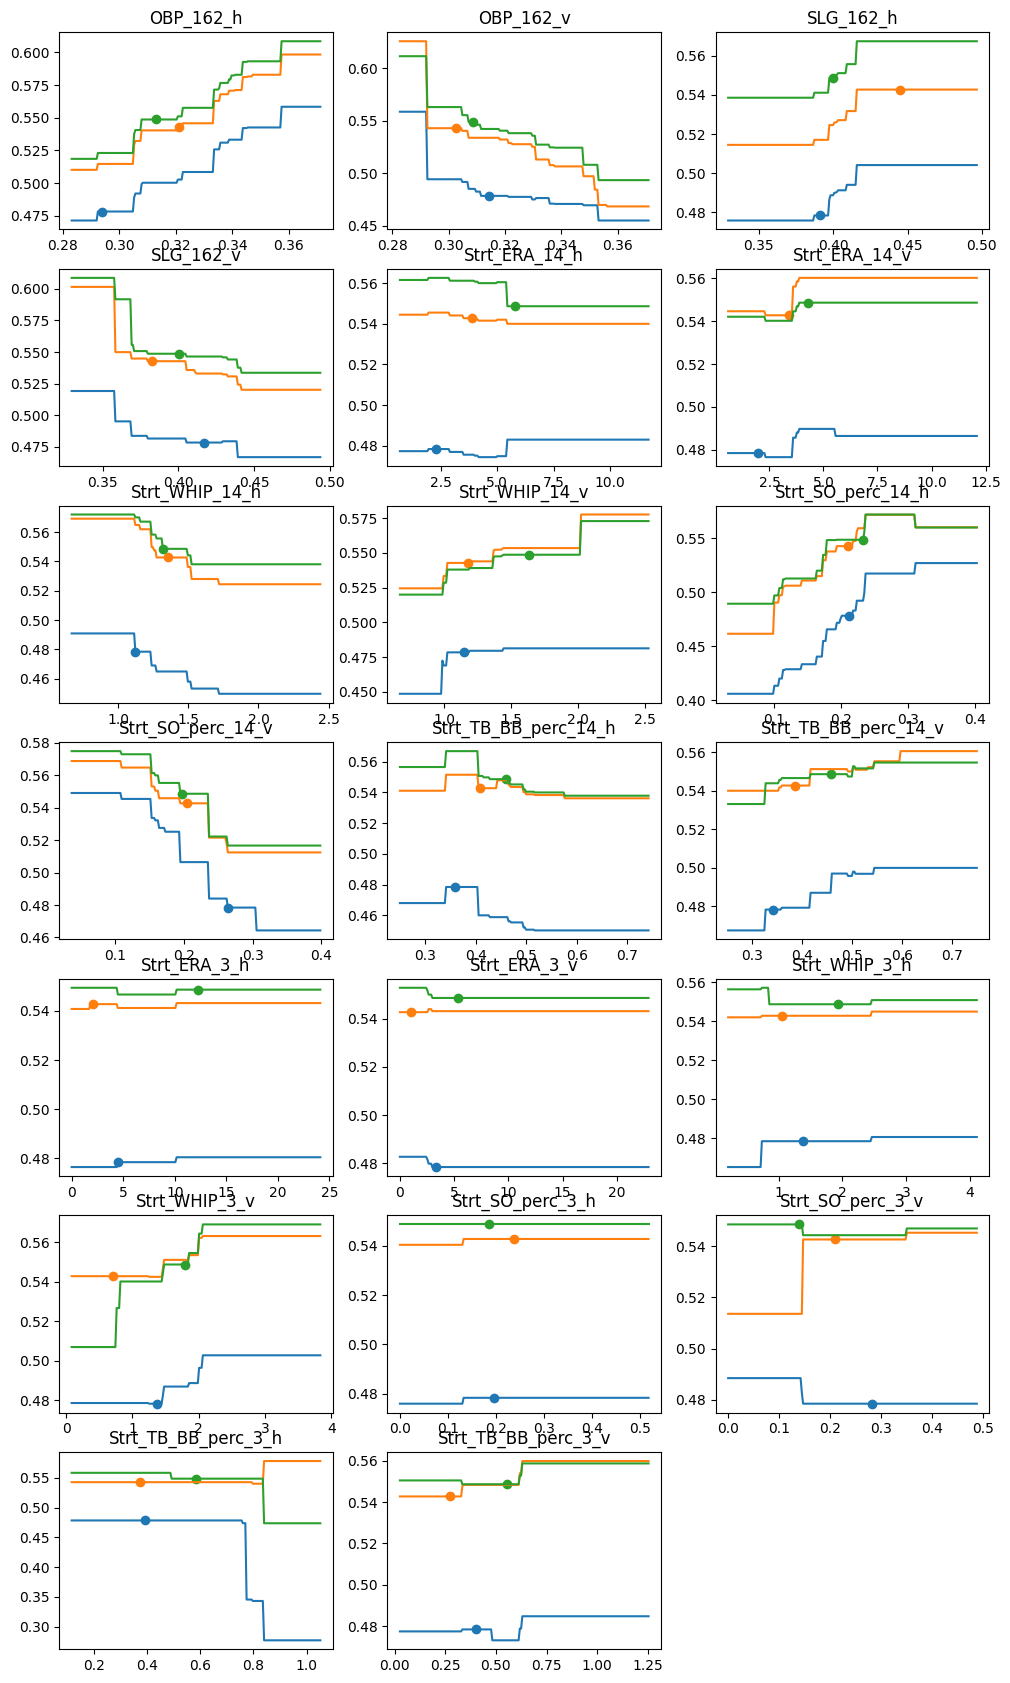

In [37]:
mli.ice_plot(lgbm1, plot_pts, X_test.columns, mli.get_range_dict(X_train), plots_per_row=3)

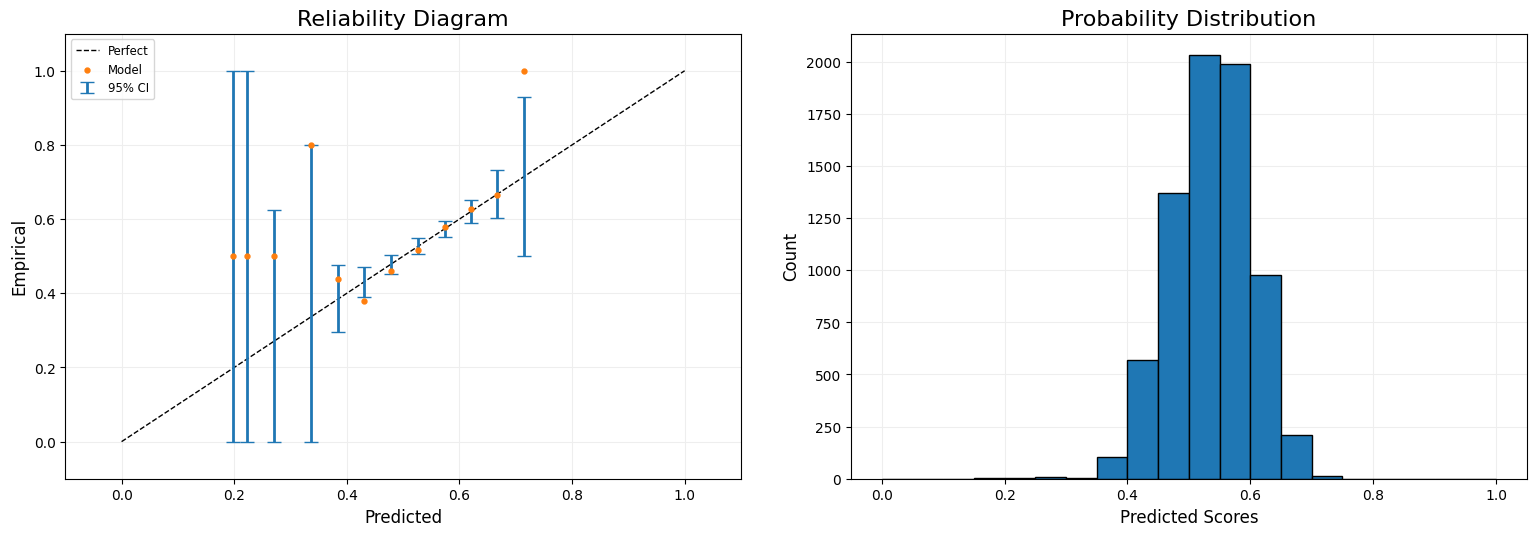

In [38]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_lgbm, show_histogram=True);

In [39]:
sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
sv_lgbm = pd.DataFrame(sv_lgbm)
sv_lgbm.columns = list(X_test.columns)+['Intercept']

In [40]:
sv_lgbm.abs().mean().sort_values(ascending=False)

Intercept               0.164996
Strt_SO_perc_14_h       0.088700
Strt_SO_perc_14_v       0.086708
OBP_162_h               0.065651
OBP_162_v               0.058597
Strt_WHIP_14_h          0.051878
SLG_162_h               0.046400
SLG_162_v               0.029322
Strt_TB_BB_perc_14_h    0.022842
Strt_WHIP_14_v          0.022740
Strt_ERA_14_v           0.020538
Strt_WHIP_3_v           0.020446
Strt_TB_BB_perc_14_v    0.016093
Strt_SO_perc_3_v        0.014179
Strt_TB_BB_perc_3_v     0.006158
Strt_ERA_14_h           0.005836
Strt_TB_BB_perc_3_h     0.005716
Strt_SO_perc_3_h        0.004841
Strt_ERA_3_v            0.004818
Strt_ERA_3_h            0.004085
Strt_WHIP_3_h           0.003555
dtype: float64

In [41]:
# Choose the best window size for each metric, drop ERA

features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            'Strt_WHIP_14_h','Strt_WHIP_14_v',
            'Strt_TB_BB_perc_14_h', 'Strt_TB_BB_perc_14_v',
            'Strt_SO_perc_14_h', 'Strt_SO_perc_14_v',
            
]
target = 'home_victory'

In [42]:
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

In [43]:
X_train.shape, X_valid.shape, X_test.shape

((36437, 10), (10615, 10), (7285, 10))

In [44]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=2)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.689906
[20]	valid_0's binary_logloss: 0.689147
[30]	valid_0's binary_logloss: 0.688448
[40]	valid_0's binary_logloss: 0.687708
[50]	valid_0's binary_logloss: 0.687034
[60]	valid_0's binary_logloss: 0.686476
[70]	valid_0's binary_logloss: 0.685904
[80]	valid_0's binary_logloss: 0.685413
[90]	valid_0's binary_logloss: 0.684908
[100]	valid_0's binary_logloss: 0.684471
[110]	valid_0's binary_logloss: 0.684148
[120]	valid_0's binary_logloss: 0.683836
[130]	valid_0's binary_logloss: 0.683524
[140]	valid_0's binary_logloss: 0.683247
[150]	valid_0's binary_logloss: 0.68303
[160]	valid_0's binary_logloss: 0.682727
[170]	valid_0's binary_logloss: 0.682514
[180]	valid_0's binary_logloss: 0.682289
[190]	valid_0's binary_logloss: 0.682092
[200]	valid_0's binary_logloss: 0.681891
[210]	valid_0's binary_logloss: 0.681737
[220]	valid_0's binary_logloss: 0.681589
[230]	valid_0's binary_logloss: 0.681406
[240]	

LGBMClassifier(learning_rate=0.02, max_depth=2, n_estimators=1000)

In [45]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

In [46]:
# now about 5 bps worse than previous model...

log_loss(y_test, preds_lgbm), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.6798726629073725, 0.6913722730242492)

In [47]:
log_loss(y_test,df_test.implied_prob_h_mid)

0.6704071693200951

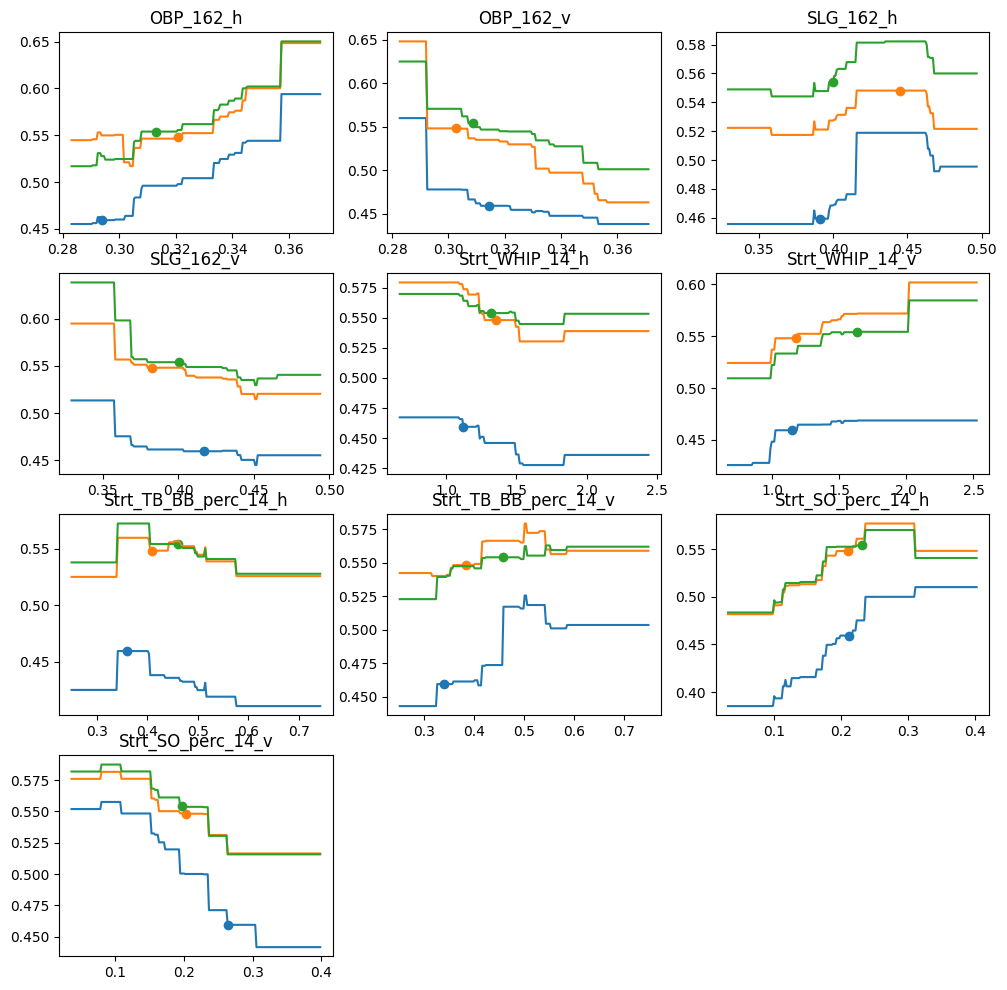

In [48]:
rd = mli.get_range_dict(X_train)
plot_pts = X_test.sample(3, random_state=42)
mli.ice_plot(lgbm1, plot_pts, X_test.columns, mli.get_range_dict(X_train), plots_per_row=3)

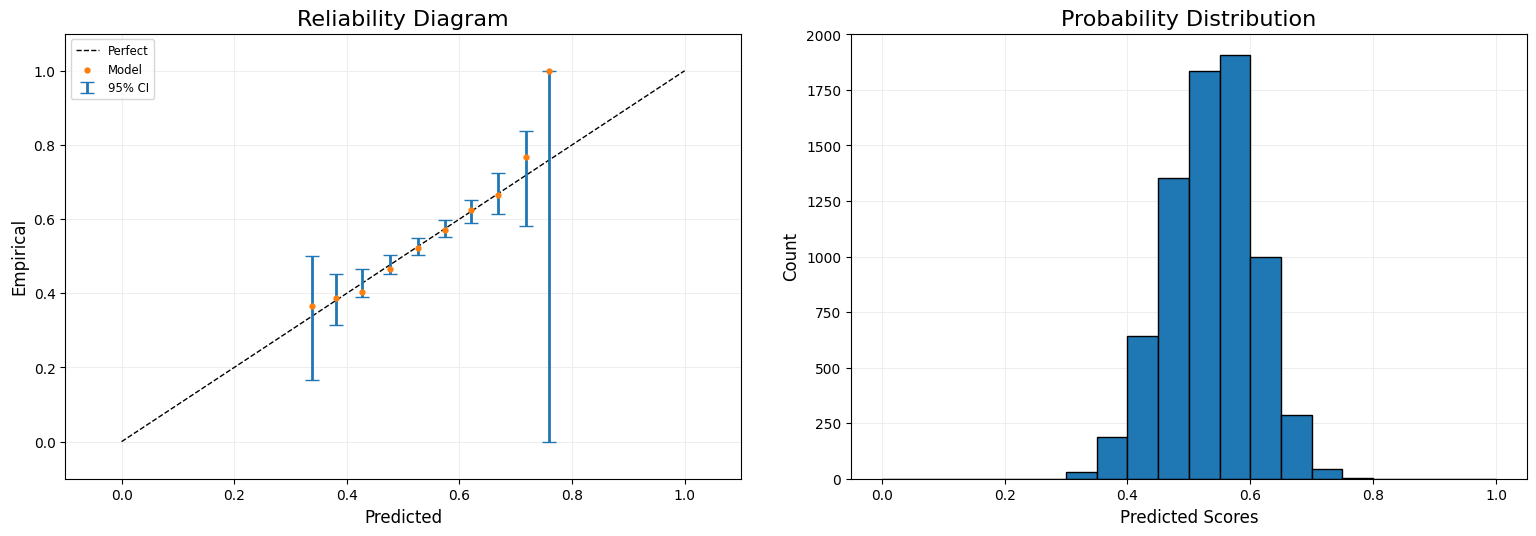

In [49]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_lgbm, show_histogram=True);

In [50]:
sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
sv_lgbm = pd.DataFrame(sv_lgbm)
sv_lgbm.columns = list(X_test.columns)+['Intercept']

In [51]:
sv_lgbm.abs().mean().sort_values(ascending=False)

Intercept               0.165278
Strt_SO_perc_14_v       0.104114
Strt_SO_perc_14_h       0.099207
OBP_162_v               0.067355
OBP_162_h               0.066328
SLG_162_h               0.056341
Strt_WHIP_14_h          0.055754
Strt_WHIP_14_v          0.040562
Strt_TB_BB_perc_14_v    0.030526
SLG_162_v               0.029799
Strt_TB_BB_perc_14_h    0.029253
dtype: float64

How much do these differences in log loss really mean?

When model A does a few bps better than model B in log loss, how should we think about that?

Is it a meaningful improvement?
How do we know it is not just "luck of the draw" of the test set
We'll run some quick simulations to build our intuition about this.

In [52]:
# Simulate a test set (with given "true" probabilities) and compare two models, 

def ll_dist(probvec_true, probvec_mod1, probvec_mod2, num_trials):
    llvec_mod1 = np.zeros(num_trials)
    llvec_mod2 = np.zeros(num_trials)
    for i in range(num_trials):
        sim_outcome = np.random.binomial(n=1, p=probvec_true)
        llvec_mod1[i] = log_loss(sim_outcome, probvec_mod1)
        llvec_mod2[i] = log_loss(sim_outcome, probvec_mod2)
    return(llvec_mod1 - llvec_mod2)

In [53]:
pv_true = df_test.implied_prob_h_mid
pv_mod1 = pv_true + np.random.uniform(-.02, .02, len(pv_true))
pv_mod2 = pv_true + np.random.uniform(-.04, .04, len(pv_true))

disc = ll_dist(pv_true, pv_mod1, pv_mod2, 10000)

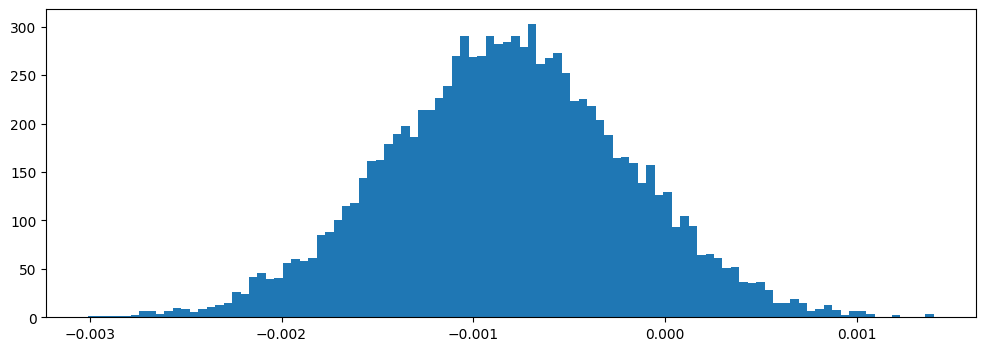

In [54]:
plt.figure(figsize=(12,4))
plt.hist(disc, bins=100);

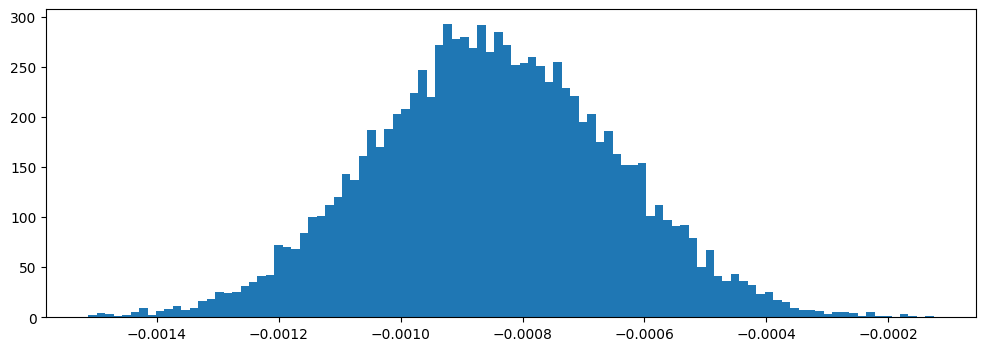

In [55]:
pv_true = np.repeat(df_test.implied_prob_h_mid,10)
pv_mod1 = pv_true + np.random.uniform(-.02, .02, len(pv_true))
pv_mod2 = pv_true + np.random.uniform(-.04, .04, len(pv_true))

disc = ll_dist(pv_true, pv_mod1, pv_mod2, 10000)
plt.figure(figsize=(12,4))
plt.hist(disc, bins=100);

In [56]:
pv_true = df_test.implied_prob_h_mid
pv_mod1 = pv_true + np.random.uniform(-.02, .02, len(pv_true))
pv_mod2 = pv_true + np.random.uniform(-.10, .10, len(pv_true))

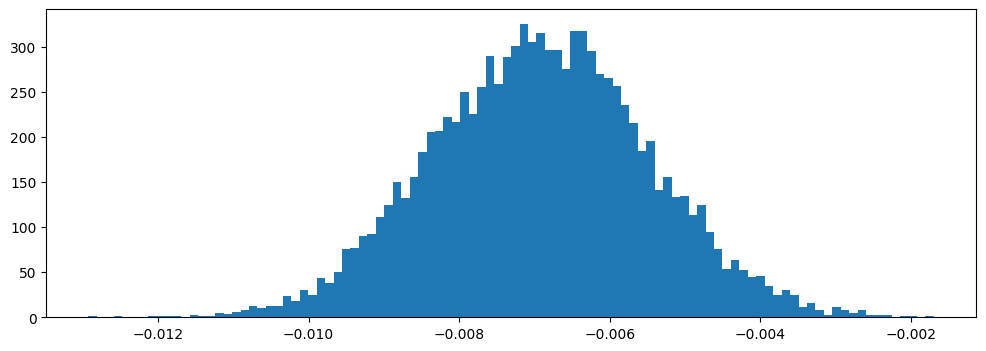

In [57]:

disc = ll_dist(pv_true, pv_mod1, pv_mod2, 10000)
plt.figure(figsize=(12,4))
plt.hist(disc, bins=100);

Conclusions

    - Could be that 5-10 bps improvement is meaningful!
    - Variation due to test set size is considerable
    - Not a simple matter to increase test set size in this problem
    - For now, still need to improve beyond minor optimizations


Potential Next Steps??

    - Have nothing about the quality of the bullpen
    - Bullpen is more meaningful in recent years, as starting pitchers work fewer innings
    - Could cause an issue with "model drift" (something to explore later on)
    - We don't account for the specific hitting lineup (would need individual batter data)
    - We have nothing about fielding
    - Several additional sources of model drift
    - Rule changes about infield positioning
    - Pitching clock
    - NL now has a DH